In [57]:
# Import packages
import plotly.express as px
import pandas as pd

In [58]:
# Read in the data
data = pd.read_csv('tea_forex.csv')
data['Year-Month'] = pd.to_datetime(data['Year-Month'])

In [59]:
def plot_production_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the production data."""

    fig = px.line(df, x='Year-Month', y=y, labels={'Year-Month': 'Month', 'Mid_Grown_Production_(Kg)': 'Production (Kg)' })
    fig.update_layout(template="simple_white", font=dict(size=18),
                      title_text='Mid Grown Tea Production', width=650,
                      title_x=0.5, height=400)

    return fig.show()

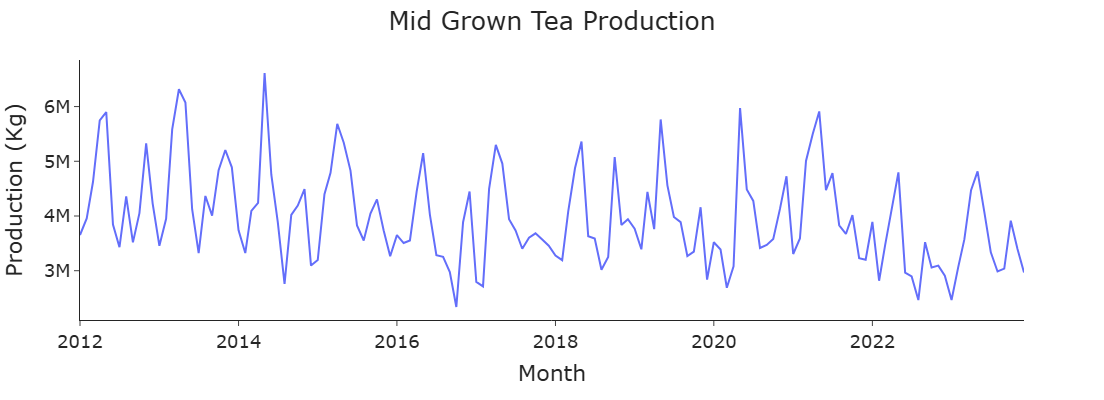

In [60]:
# Plot the mid grown production data
plot_production_volumes(df=data, y='Mid_Grown_Production_(Kg)')

In [61]:
# Import adf test
from statsmodels.tsa.stattools import adfuller

In [62]:
def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

In [63]:
adf_test(data["Mid_Grown_Production_(Kg)"][12:])

ADF Statistic:  -2.2257323001969507
P-Value:  0.19703900886494186
Critical Values:
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [64]:
# Import packages 
from scipy.stats import boxcox

In [65]:
# Make the target variance stationary
data['Production_Boxcox'], lam = boxcox(data['Mid_Grown_Production_(Kg)'])

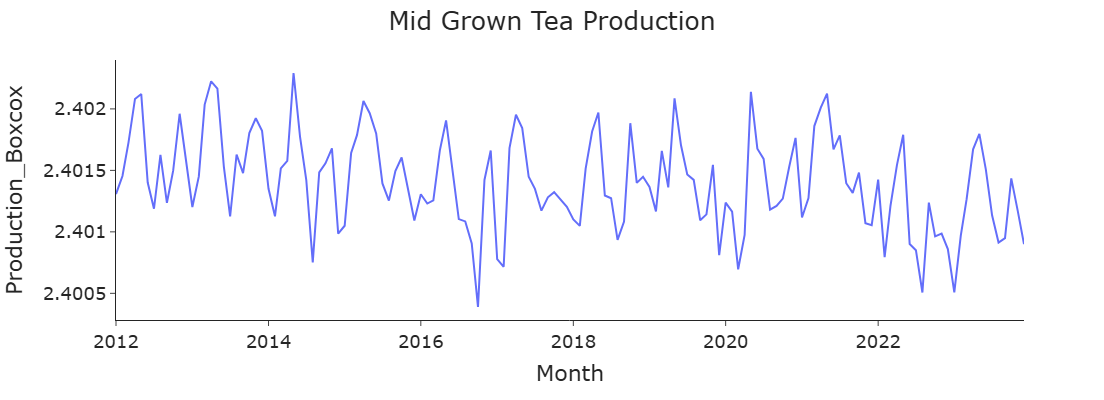

In [66]:
# Plot the box-cox production data
plot_production_volumes(df=data, y='Production_Boxcox')

In [67]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [68]:
# Difference the data
data["Production_diff"] = data["Production_Boxcox"].diff()
data.dropna(inplace=True)

In [69]:
adf_test(data["Production_diff"][12:])

ADF Statistic:  -3.629791365764512
P-Value:  0.005216367719956216
Critical Values:
	1%: -3.49
	5%: -2.89
	10%: -2.58


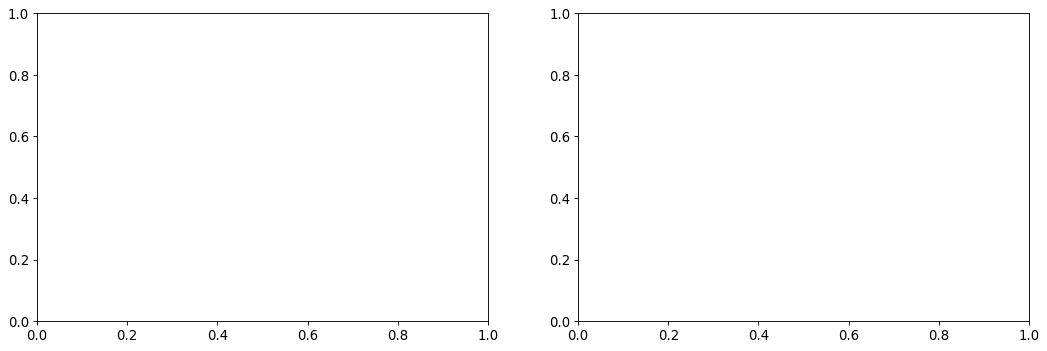

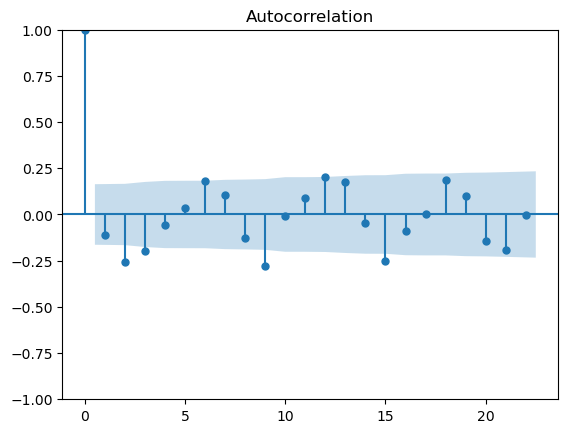

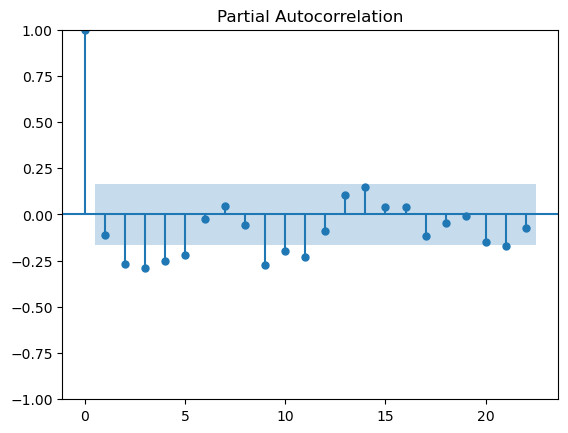

In [70]:
# Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(data['Production_diff'])
plot_pacf(data['Production_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [71]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

In [72]:
# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

In [88]:
# Build ARIMA model and inverse the boxcox
model = ARIMA(train['Production_Boxcox'], order=(11, 2, 15)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\hasit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: Fut

In [89]:
# Import packages
import plotly.graph_objects as go

In [90]:
def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Year-Month'], y=train['Mid_Grown_Production_(Kg)'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Year-Month'], y=test['Mid_Grown_Production_(Kg)'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Year-Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=14), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Month',
                      yaxis_title='Production Volume')

    return fig.show()

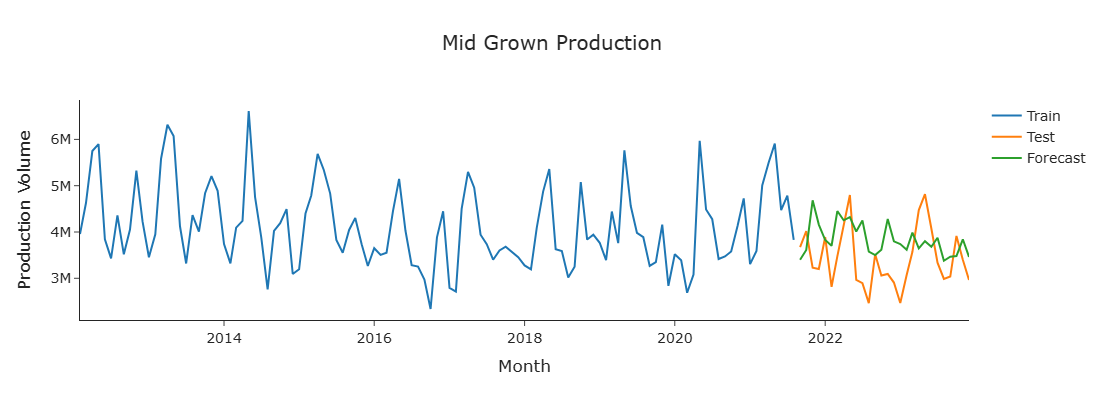

In [91]:
# Plot the forecasts
plot_forecasts(forecasts, 'Mid Grown Production')

In [93]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Production_Boxcox   No. Observations:                  115
Model:               ARIMA(11, 2, 15)   Log Likelihood                 704.519
Date:                Sat, 15 Mar 2025   AIC                          -1355.038
Time:                        12:44:34   BIC                          -1281.398
Sample:                             0   HQIC                         -1325.155
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7103      0.142     -5.005      0.000      -0.988      -0.432
ar.L2         -0.9451      0.265     -3.564      0.000      -1.465      -0.425
ar.L3         -0.8553      0.158     -5.400      0.000      -1.166      -0.545
ar.L4         -0.6946      0.189     -3.676      0.000      -1.065      -0.324
ar.L5         -0.9398      0.169     -5.567      0.000      -1.271      -0.609
ar.L6         -0.5849      0.221     -2.643      0.008      -1.019      -0.151
ar.L7         -0.7108      0.141     -5.058      0.000      -0.986      -0.435
ar.L8         -0.3802      0.186     -2.043      0.041      -0.745      -0.016
ar.L9         -0.5088      0.150     -3.387      0.001      -0.803      -0.214
ar.L10        -0.4635      0.252     -1.839      0.066      -0.957       0.031
ar.L11        -0.3320      0.161     -2.065      0.039      -0.647      -0.017
ma.L1      -8.298e-07      0.198   -4.2e-06      1.000      -0.387       0.387
ma.L2       1.318e-07      0.243   5.43e-07      1.000      -0.476       0.476
ma.L3      -6.479e-07      0.255  -2.54e-06      1.000      -0.501       0.501
ma.L4       4.425e-08      0.397   1.11e-07      1.000      -0.779       0.779
ma.L5      -5.092e-07      0.405  -1.26e-06      1.000      -0.793       0.793
ma.L6      -9.151e-09      0.324  -2.82e-08      1.000      -0.636       0.636
ma.L7      -5.576e-07      0.359  -1.55e-06      1.000      -0.703       0.703
ma.L8       1.214e-08      0.366   3.32e-08      1.000      -0.717       0.717
ma.L9      -6.041e-07      0.214  -2.83e-06      1.000      -0.419       0.419
ma.L10      1.063e-07      0.375   2.84e-07      1.000      -0.735       0.735
ma.L11     -6.144e-07      0.358  -1.72e-06      1.000      -0.702       0.702
ma.L12      3.902e-08      0.324    1.2e-07      1.000      -0.636       0.636
ma.L13     -5.923e-07      0.298  -1.99e-06      1.000      -0.585       0.585
ma.L14      9.526e-08      0.248   3.84e-07      1.000      -0.487       0.487
ma.L15     -6.472e-07      0.172  -3.76e-06      1.000      -0.337       0.337
sigma2      2.059e-07   4.62e-08      4.458      0.000    1.15e-07    2.96e-07
===================================================================================
Ljung-Box (L1) (Q):                  31.91   Jarque-Bera (JB):                 0.78
Prob(Q):                              0.00   Prob(JB):                         0.68
Heteroskedasticity (H):               1.37   Skew:                             0.17
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.73e+17. Standard errors may be unstable.
"""